In [85]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [86]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
# using Lazy

In [87]:
using PotentialFlow
import PotentialFlow.Utils: @get

In [88]:
using ProgressMeter
using LinearAlgebra
using Statistics
using ColorSchemes

In [89]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

Plots.PyPlotBackend()

In [90]:
# if !Plots.is_installed("PyPlot")
#     Pkg.add("PyPlot")
# end
# withenv("PYTHON" => "") do
#     Pkg.build("PyPlot")
# end

## Load CFD Data

In [91]:
using FileIO
using Interpolations

In [92]:
# re500_data = load(expanduser("/home/matmat/Documents/PhD/VortexModel/DarwinVortex/data/re500_aoa20.jld2")) # No Pulse
# re500_data = load(expanduser("~/Documents/Research/data/rey500_pulse01_data.jld2"))
re500_data = load(expanduser("/media/mat/HDD/VortexModels/data/rey500_aoa20_2pulse01_data.jld2"))

Dict{String,Any} with 6 entries:
  "pressure"  => Dict{String,Any}("t"=>0.05:0.05:10.0,"edges"=>(-0.5, 0.5),"s"=…
  "Re"        => 500
  "aoa"       => 0.349066
  "force"     => Dict{String,Any}("t"=>0.001:0.001:10.0,"F"=>Complex{Float64}[-…
  "vorticity" => Dict{String,Any}("x"=>[-0.996, -0.992, -0.988, -0.984, -0.98, …
  "actuation" => ((3.0, 4.0), 0.01)

In [93]:
pressure_data = let pressure = -re500_data["pressure"]["p"],
    T = re500_data["pressure"]["t"],
    s = re500_data["pressure"]["s"],
    le = re500_data["pressure"]["edges"][1]
    
#     scale(interpolate(reverse(pressure, dims = 1), BSpline(Cubic(Line(OnGrid())))), 
#         reverse(sign(le)*s, dims = 1), T, extrapolation  = Flat())
    CubicSplineInterpolation((reverse(sign(le)*s), T),reverse(pressure, dims = 1), extrapolation_bc =  Line())
end;

In [94]:
function cfd_pressure(t, taps, config, pressure_data)
    s = [-0.5config.L*cos(n*π/(config.N-1)) for n in taps]
    [pressure_data(i,t) for i in s]
end

cfd_pressure (generic function with 1 method)

In [95]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [96]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

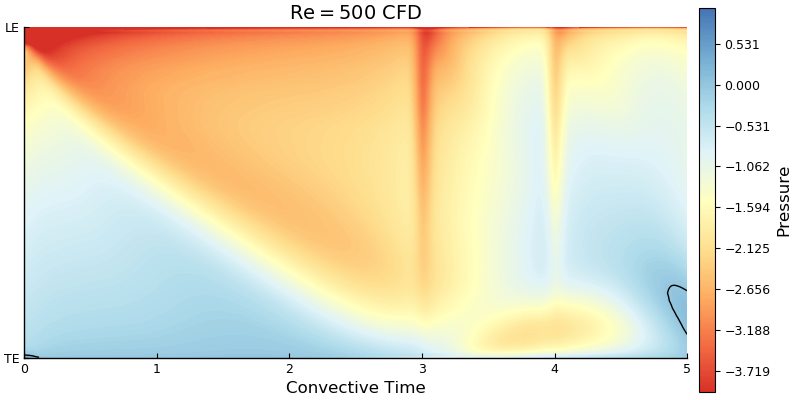

In [97]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
        
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
    contour!(T, s, cfd_pressures,levels=0:0,seriescolor=:black)
end
# savefig("test1.pdf")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

## Model Formulation

We have a flat plate that is translating at a fixed angle of attack and velocity.
We also use a constant blob radius on all of our vortex elements

In [98]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end

In [99]:
include("/media/mat/HDD/VortexModels/SparseVortex/Jupyter notebooks/merging_model.jl")
include("/media/mat/HDD/EnKF/notebooks/VortexEnKF.jl")

VortexENKF (generic function with 1 method)

In [100]:
#### Define size of the ensemble and measurement vector N and NZ, respectively
N = 50 
NZ = 50

#### Define measurement and real measurement functions m and z, respectively 
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return measure_state(s, t, config, pressure_taps)
end

m = MeasurementFunction()

function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    
    real_meas = cfd_pressure(t, pressure_taps, config, pressure_data)
    
    fill!(ENS, real_meas)
    
    return ENS
end

z = RealMeasurementFunction()

#### Covariance inflation

β = 1.01
ri = RecipeInflation([1e-5,1e-5, 5e-5,0.0, β, 0])
ϵ = AdditiveInflation(MvNormal(zeros(NZ), 1.0*10^-4*I));

#### Initialize config

In [101]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

#### Distribution perturbation initial state

In [136]:
lesp₀ = 0.5 #0.5
tesp₀ = 0.0
lesprand = 0.1 #0.1
Distx₀ = TupleProduct((TruncatedNormal(lesp₀, lesprand, 0.0, 3.0),
            Normal(tesp₀, 0.0)))
ens = initialize(N, Distx₀)

states = [deepcopy(ens.S)]#[map((a,b) -> [a, b], lesps, tesps)];

covs = [];

In [137]:
vortexenkf = VortexENKF(N, NZ, ri, m, z, ϵ)

ENKF{50,50}(PropagationFunction(), RecipeInflation(Real[1.0e-5, 1.0e-5, 5.0e-5, 0.0, 1.01, 501]), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{50}(IsoNormal(
dim: 50
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0e-8 0.0 … 0.0 0.0; 0.0 1.0e-8 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-8 0.0; 0.0 0.0 … 0.0 1.0e-8]
)
), true, true, true)

#### Time marching

In [138]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

t = 0.0
@showprogress for (n,ti) in enumerate(T)

    ri.p[6] = deepcopy(n)
    global t, ens
    t, ens,cov = vortexenkf(t, config.Δt, ens)
#     print(t)
    push!(states, deepcopy(ens.S))
    push!(covs, deepcopy(cov))

end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


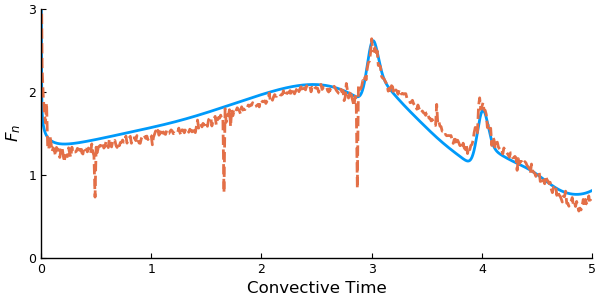

In [139]:
f = regen_forces(T, mean.(states), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [106]:
# f = regen_forces(T, mean.(states), config);
# plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
# legend = false, linewidth = 2)
# plot!(T, 2abs.(f)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
# linewidth = 2, linestyle = :dash)
# # savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

In [107]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(layout = (2,1), size = (800, 400))
    contourf!(T, s, [cfd_pressures, model_pressures], title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
# savefig("EnKF\ Results/Re500

ErrorException: type Array has no field surf

In [108]:
# let s = [-0.5config.L*cos(θ) for θ in linspace(0, π, config.N)][pressure_taps],
#     model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
#     plt = plot(layout = (2,1), size = (800, 400))
#     contourf!(T, s, [cfd_pressures, model_pressures], title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
#         levels = linspace(-2, 2, 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
#         yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
# end
# # savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

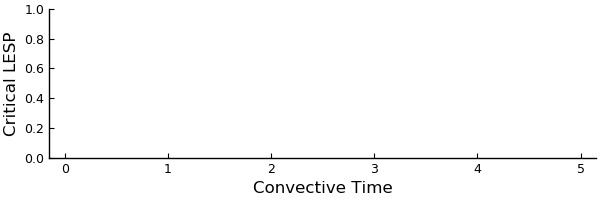

In [109]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

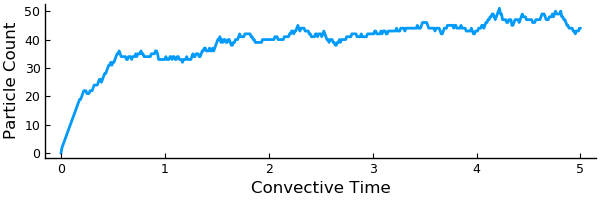

In [110]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

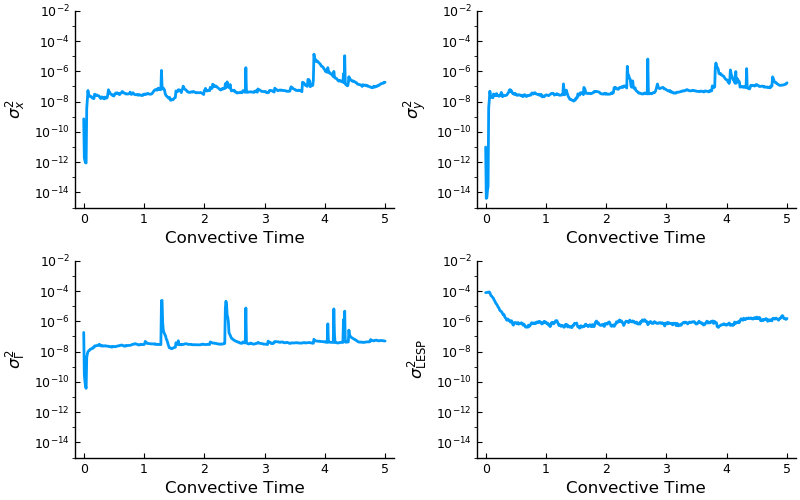

In [111]:
plt = plot(layout = (2,2), size = (800, 500), legend = false)
plot!(plt[1], T, map(covs) do P
        mean(diag(P)[1:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_x^2\$")
plot!(plt[2], T, map(covs) do P
        mean(diag(P)[2:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_y^2\$")
plot!(plt[3],T,  map(covs) do P
        mean(diag(P)[3:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\Gamma^2\$")
plot!(plt[4], T, map(covs) do P
        mean(diag(P)[end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/covariance.pdf")

### Snapshot Figures

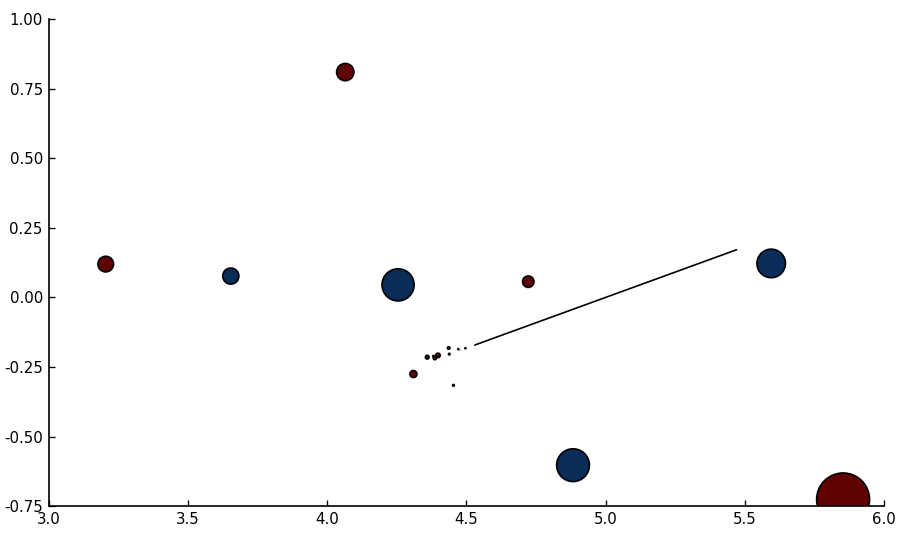

In [112]:
n = 500
# for n in [250, 300, 350, 400, 450, 500]
plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
plot!(plt, Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt, state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1), xticks = (n/100 - 2):0.5:(n/100 + 1)
)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/enkf_t$(lpad(n, 3, 0)).pdf")

# plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
# contour!(plt, n/100 - re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
#     transpose(re500_data["vorticity"]["vorticity"][n÷5]), levels = linspace(-30, 30, 100),
#     color = :RdBu, clim = (-20, 20),
#     xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = (n/100 - 2):0.5:(n/100 + 1))
# savefig("EnKF\ Results/Re500/2pulse01/multiplicative_inflation/cfd_t$(lpad(n, 3, 0)).pdf")
# end

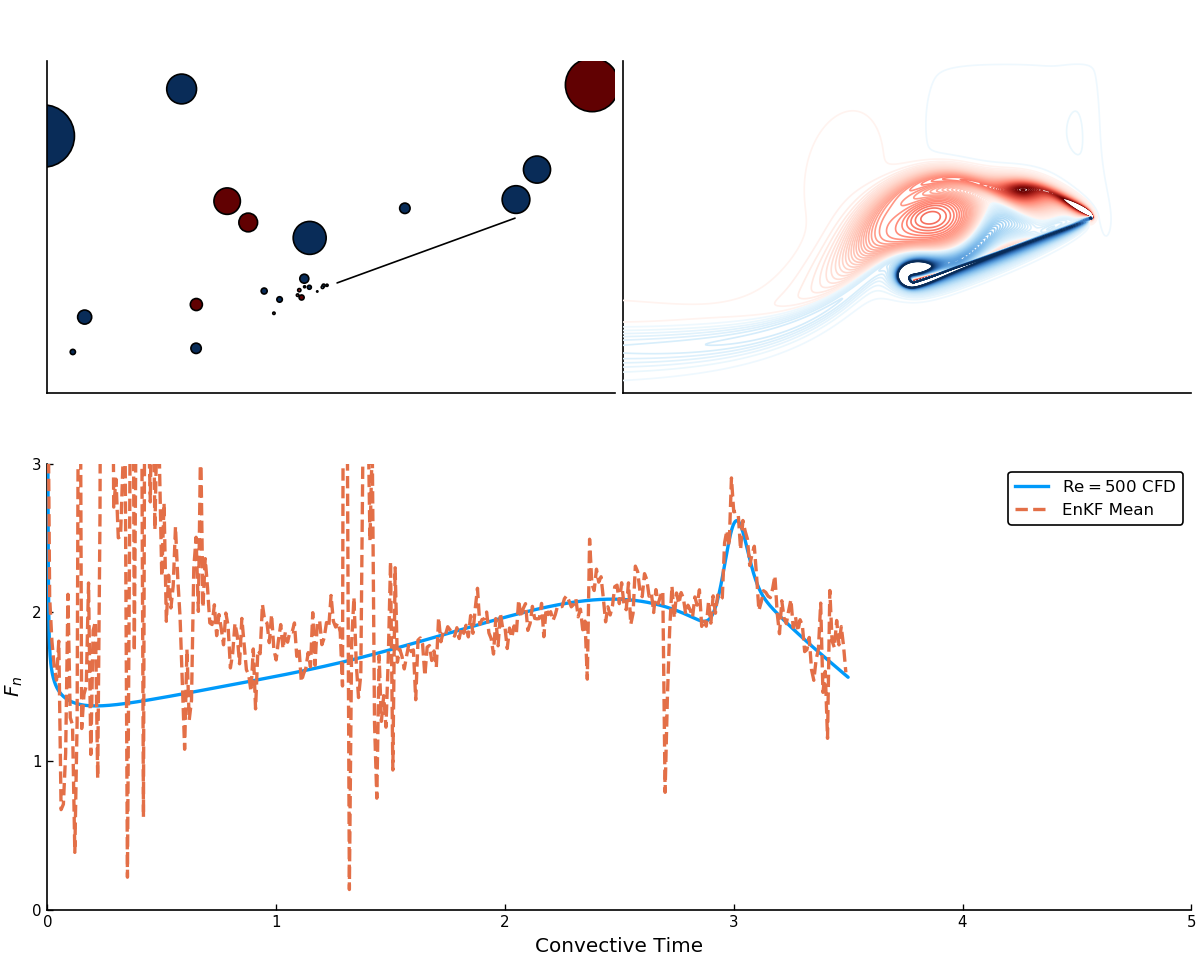

In [113]:
f = regen_forces(T, mean.(states), config);
n = 350
# @showprogress for (i,n) in enumerate(5:5:500)
l = @layout [  grid(1, 2)
               b{0.5h} ]

plt = plot(layout = l, colorbar = :none, size = (1000, 800), dpi = 120)
plot!(plt[1], Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt[1], state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1),
    xticks = [], yticks = [])
    contour!(plt[2], re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
    reverse(transpose(re500_data["vorticity"]["vorticity"][n÷5 + 1]), dims = 2), levels = range(-20.0, stop = 20.0, length = 100),
    color = cgrad((colormap("RdBu"))), clim = (-20, 20),
    xlim = (1.5, 4.5), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = [], yticks = []
)   
plot!(plt[3], re500_data["force"]["t"][1:10n], abs.(re500_data["force"]["F"][1:10n]), linewidth = 2, label = "\$\\mathrm{Re} = 500\$ CFD")
plot!(plt[3], T[1:n], 2abs.(f)[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))
# plot!(plt[3], T[1:n], abs.(re500_data["force"]["F"])[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))

# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/state_$(lpad(i,3,0)).png")
# end

In [114]:
# # for n in [3, 4, 6, 8]
# n = 3
# let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
#     model_pressures = hcat((measure_state(states[i+1][n], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
# #     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
#     plt = plot(size = (800, 200))
#     contourf!(T[1:300], s, model_pressures,
#         levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
#         yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
# end
# savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")
# # end

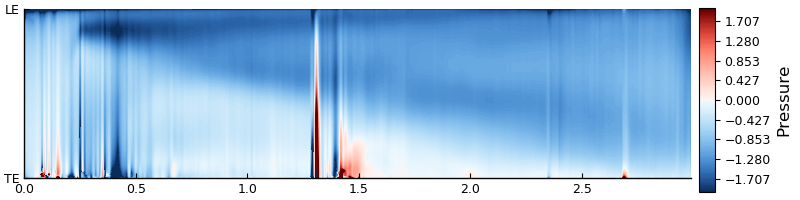

In [115]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(states[i+1][1], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(size = (800, 200))
    contourf!(T[1:300], s, model_pressures,
        levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
#savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")